ТОЛЬКО ВТОРАЯ ЧАСТЬ ЗАДАНИЯ:

Выполните сегментирование этого же изображения при помощи глубокой нейронной сети, рассмотренной в примере

In [1]:
import os
from os.path import exists, join, basename, splitext

import random
import PIL
import torchvision
import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)

import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model = model.eval().cpu()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 126MB/s]


Загрузим и считаем изображение

In [2]:
!gdown 14CSVdok0NTd9NRHKv2WXg34Z7Wykui8A
image_file = '/content/cv53.jpg'

Downloading...
From: https://drive.google.com/uc?id=14CSVdok0NTd9NRHKv2WXg34Z7Wykui8A
To: /content/example_image.jpg
100% 164k/164k [00:00<00:00, 85.9MB/s]


In [3]:
t = time.time()
image = PIL.Image.open(image_file)
image_tensor = torchvision.transforms.functional.to_tensor(image).cpu()
output = model([image_tensor])[0]
print('Время распознавания: %.3fs' % (time.time() - t))

Время распознавания: 11.222s


In [4]:
output.keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [5]:
coco_names = ['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [6]:
result = {}
result['masks'] = []
result['labels'] = []
result['scores'] = []
result['boxes'] = []

for i in range(len(output['scores'])):
  if output['scores'][i] <= 0.5:
    continue
  # Исправляем маски
  one_mask = output['masks'][i][0].cpu().numpy()
  one_mask[one_mask >= np.max(one_mask) * 0.5] = 1
  one_mask[one_mask < np.max(one_mask) * 0.5] = 0
  result['masks'].append(one_mask)
  # Исправляем коробки
  result['boxes'].append(output['boxes'][i].int().cpu().numpy())
  # Добавляем остальное
  result['scores'].append(output['scores'][i].cpu().numpy())
  result['labels'].append(output['labels'][i].cpu().numpy())

Визуально по картинке определяем объект с наибольшей площадью, затем ищем его в выводe (он должен быть с самой большой долей).

car: доля: 0.0143, вероятность: 0.9983  Границы:  (371, 246) (57, 47)
car: доля: 0.0347, вероятность: 0.9976  Границы:  (138, 288) (89, 73)
person: доля: 0.0017, вероятность: 0.9902  Границы:  (155, 207) (13, 25)
car: доля: 0.0070, вероятность: 0.9899  Границы:  (0, 241) (32, 41)
car: доля: 0.0049, вероятность: 0.9834  Границы:  (473, 237) (26, 35)
traffic light: доля: 0.0062, вероятность: 0.9828  Границы:  (326, 142) (22, 53)
traffic light: доля: 0.0012, вероятность: 0.9822  Границы:  (273, 167) (9, 24)
traffic light: доля: 0.0064, вероятность: 0.9819  Границы:  (298, 142) (23, 52)
traffic light: доля: 0.0015, вероятность: 0.9778  Границы:  (455, 181) (11, 26)
car: доля: 0.0046, вероятность: 0.9754  Границы:  (286, 227) (33, 26)
traffic light: доля: 0.0019, вероятность: 0.9648  Границы:  (305, 277) (13, 27)
car: доля: 0.0033, вероятность: 0.9183  Границы:  (102, 208) (26, 24)
person: доля: 0.0004, вероятность: 0.9159  Границы:  (188, 199) (6, 14)
car: доля: 0.0031, вероятность: 0.9147

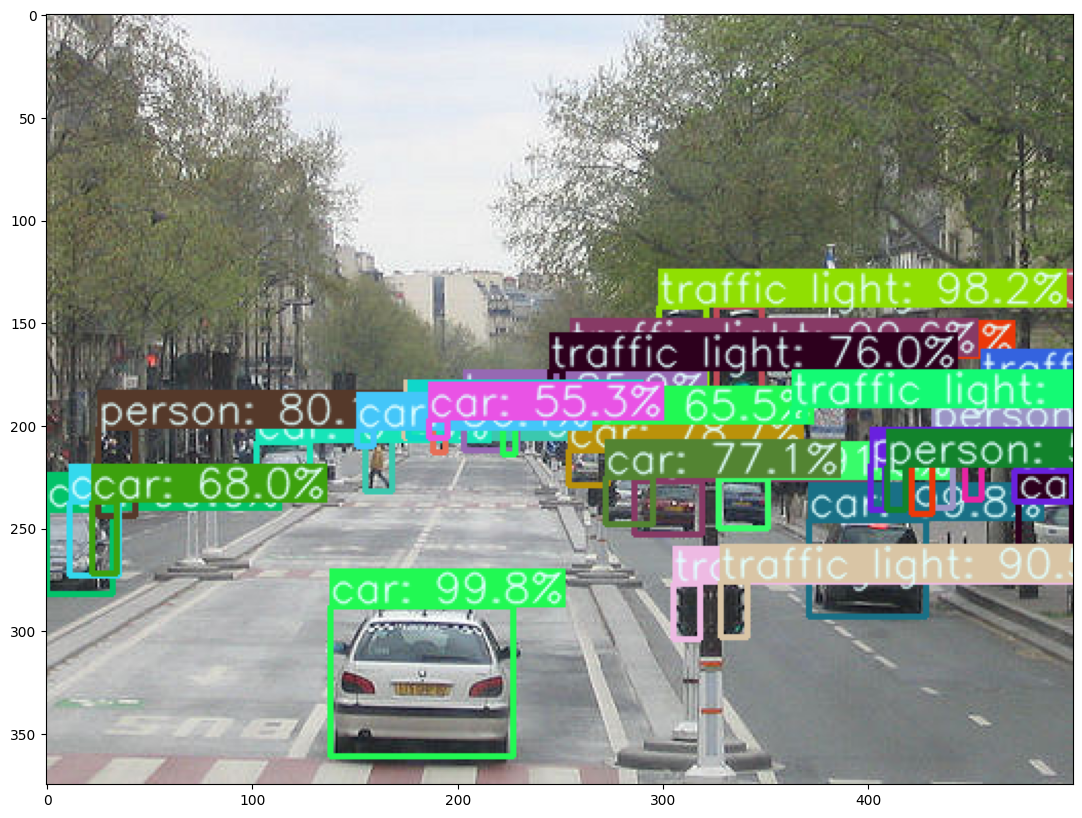

In [14]:
colors = [[random.randint(0, 255) for _ in range(3)] for _ in coco_names]

result_image = np.array(image.copy())
for box, label, score, mask in zip(result['boxes'], result['labels'], result['scores'], result['masks']):
  color = random.choice(colors)

  # draw box
  tl = round(0.002 * max(result_image.shape[0:2])) + 1  # line thickness
  c1, c2 = (box[0], box[1]), (box[2], box[3])
  dc = (box[2] - box[0], box[3] - box[1])
  pl = dc[0] * dc [1] / (len(result_image) * len(result_image[0]))
  print("%s: доля: %.4f, вероятность: %.4f" % (coco_names[label], pl, score), " Границы: ", c1, dc)
  cv2.rectangle(result_image, c1, c2, color, thickness=tl)
  # draw text
  display_txt = "%s: %.1f%%" % (coco_names[label], 100*score)
  tf = max(tl - 1, 1)  # font thickness
  t_size = cv2.getTextSize(display_txt, 0, fontScale=tl / 3, thickness=tf)[0]
  c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
  cv2.rectangle(result_image, c1, c2, color, -1)  # filled
  cv2.putText(result_image, display_txt, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

plt.figure(figsize=(15, 10))
plt.imshow(result_image)